Use the transitative properties of the Elo rating system to simulate new matches.

However we would might see that A < B < C < D < E < C

This is a cyclic dependency and we need to handle it. 

The Idea is to make a dictionary "trans_wins_and_loses" which has the following structure

trans_wins_and_loses = {a: {W: {b, c, d}, L: {d, e, f}}, b: {W: {d, e, f}, L: {f}}, ...}

Where the "W" set for image "a" is filled with the wins that image "a" both have and would have had given transitative properties. From this it is possible to create a new dictionary, called pure wins.

pure_wins = {a: {b, c}, b: {d, e}, ...}

Here the intersection betwen "W" and "L" are removed from "W" such that only pure "W" are present. 

To find them all we to go through them in a DFS algorithm manner.

I imagine that 

In [1]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


In [3]:
def load_match_data(filename):
    """ Load match history from a JSON file. """
    with open(filename, 'r') as file:
        return json.load(file)

In [5]:
image_names = load_match_data('../scores/full/elo/kasper.json')
match_data = load_match_data('../scores/full/elo/kasper_history.json')

In [6]:
# Initialize the dictionary for tracking wins and losses
transitative_wins_and_loses = {}
for image_name in image_names.keys():
    transitative_wins_and_loses[image_name] = {"W": set(), "L": set()}

# Go trough each session which actually happend
for session in match_data.keys():
    for match in match_data[session]:
        
        if match_data[session][match]["winner"] == 0:
            winner = match_data[session][match]["left_image"]
            loser = match_data[session][match]["right_image"]
            
        elif match_data[session][match]["winner"] == 1:
            loser = match_data[session][match]["left_image"]
            winner = match_data[session][match]["right_image"]
        
        else:
            draw_1 = match_data[session][match]["left_image"]
            draw_2 = match_data[session][match]["right_image"]
            # TODO implement draw
        
        transitative_wins_and_loses[winner]["W"].add(loser)
        transitative_wins_and_loses[loser]["L"].add(winner)


print(f"last winner: {winner}, {transitative_wins_and_loses[winner]}")
print(f"last loser: {loser}, {transitative_wins_and_loses[loser]}")
        

last winner: 1107982080.jpg, {'W': {'1107972788.jpg', '1107891189.jpg', '1107948238.jpg'}, 'L': {'1107998391.jpg', '1107987072.jpg', '1107988593.jpg'}}
last loser: 1107891189.jpg, {'W': {'1107849731.jpg', '1107840857.jpg'}, 'L': {'1107905702.jpg', '1108800014.jpg', '1107982080.jpg', '1107894352.jpg'}}


In [7]:
# Now we will implement the transitive DFS algorithm
pure_wins = dict()
i = 0

for image in transitative_wins_and_loses.keys():
    # print(f"Image: {image}")
    
    # Go trough search list for wins untill it is empty
    image_wins_set = set()
    win_search_list = list(transitative_wins_and_loses[image]["W"])
    while win_search_list:
        beaten_image = win_search_list.pop()
        if beaten_image not in image_wins_set:
            image_wins_set.add(beaten_image)

            for beaten_image_win in transitative_wins_and_loses[beaten_image]["W"]:
                win_search_list.append(beaten_image_win)
    
    # print(f"will beat {len(image_wins_set)} images: {image_wins_set}")  
          
    # Go trough search list for losses untill it is empty
    image_loss_set = set()
    loss_search_list = list(transitative_wins_and_loses[image]["L"])
    while loss_search_list:
        beaten_by_image = loss_search_list.pop()
        if beaten_by_image not in image_loss_set:
            image_loss_set.add(beaten_by_image)

            for beaten_image_loss in transitative_wins_and_loses[beaten_by_image]["L"]:
                loss_search_list.append(beaten_image_loss) 
    
    # print(f"beaten by {len(image_loss_set)} images: {image_loss_set}")
    
    
    pure_wins[image] = image_wins_set - image_loss_set
    # print(f"pure wins {len(pure_wins[image])} images: {pure_wins[image]}")
    
    # print("--------------------")
    # i += 1
    # if i == 5:
    #     break

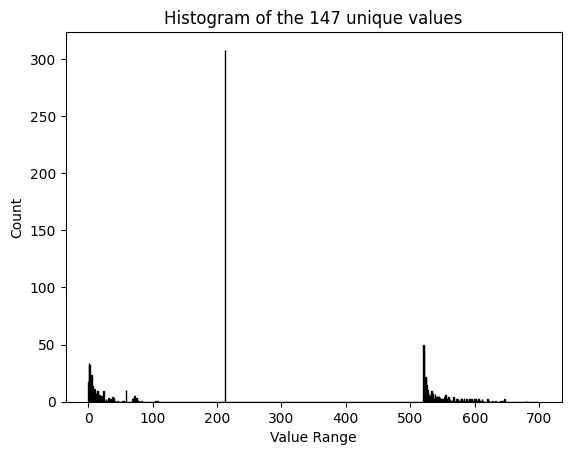

In [9]:
# How many diffrent values are there
all_values = []
for values in pure_wins.values():
    all_values.append(len(values))
    
all_values_set = set(all_values)

# Create a histogram of the values
plt.hist(all_values, range=[0, 700], bins=700, color='blue', edgecolor='black') 

# Add titles and labels
plt.title(f'Histogram of the {len(all_values_set)} unique values')
plt.xlabel('Value Range')
plt.ylabel('Count')

# Show the plot
plt.show()


In [11]:
print(pure_wins[image])

{'1108176529.jpg', '1107821663.jpg', '1107839614.jpg', '1108723163.jpg', '1107297276.jpg', '1108353262.jpg', '1108014346.jpg', '1108887391.jpg', '1108895395.jpg', '1108690584.jpg', '1108558151.jpg', '1107400009.jpg', '1108480248.jpg', '1108034318.jpg', '1108086154.jpg', '1108097514.jpg', '1107437701.jpg', '1107462700.jpg', '1108295226.jpg', '1107930197.jpg', '1108371573.jpg', '1108117103.jpg', '1108674371.jpg', '1108161250.jpg', '1108453013.jpg', '1108126278.jpg', '1108255822.jpg', '1108793500.jpg', '1108794495.jpg', '1108235735.jpg', '1108488771.jpg', '1108674402.jpg', '1108405320.jpg', '1108705832.jpg', '1108665331.jpg', '1107491703.jpg', '1108768160.jpg', '1108090323.jpg', '1107826050.jpg', '1108069437.jpg', '1108331977.jpg', '1107822828.jpg', '1108231546.jpg', '1108065027.jpg', '1108413756.jpg', '1108718334.jpg', '1108084582.jpg', '1108091588.jpg', '1108620443.jpg', '1107445590.jpg', '1107696759.jpg', '1108835078.jpg', '1108173692.jpg', '1108352960.jpg', '1108688452.jpg', '11078324

In [17]:
def create_upcoming_match_list(pure_wins):
    upcoming_matches = []
    for image in pure_wins.keys():
        for loser in pure_wins[image]:
            upcoming_matches.append((image, loser))
    return upcoming_matches

In [18]:
upcoming_matches = create_upcoming_match_list(pure_wins)

In [37]:
import random

my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
random.shuffle(my_list)
print(my_list)

[9, 2, 1, 8, 7, 3, 10, 6, 5, 4]


In [38]:
k = 0
for match in upcoming_matches:
    print(f"Match {k}: {match[0]} vs {match[1]}, type: {type(match)}")
    k += 1
    if k == 10:
        break
    

Match 0: 1099890139.jpg vs 1108176529.jpg, type: <class 'tuple'>
Match 1: 1099890139.jpg vs 1107821663.jpg, type: <class 'tuple'>
Match 2: 1099890139.jpg vs 1107839614.jpg, type: <class 'tuple'>
Match 3: 1099890139.jpg vs 1108723163.jpg, type: <class 'tuple'>
Match 4: 1099890139.jpg vs 1107297276.jpg, type: <class 'tuple'>
Match 5: 1099890139.jpg vs 1108353262.jpg, type: <class 'tuple'>
Match 6: 1099890139.jpg vs 1108014346.jpg, type: <class 'tuple'>
Match 7: 1099890139.jpg vs 1108887391.jpg, type: <class 'tuple'>
Match 8: 1099890139.jpg vs 1108895395.jpg, type: <class 'tuple'>
Match 9: 1099890139.jpg vs 1108690584.jpg, type: <class 'tuple'>
